## Time Series Modeling with Claude2

In [3]:
#environment = 'PROD'
mainFolder = '//LSFS/BOSTON/Dept/FIM/HF2/PY/EM Model'
projFolder = mainFolder + '/NLP'
outFPath = "//LSFS/BOSTON/Dept/FIM/HF2/PY/EM Model/NLP/"

In [67]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.captureWarnings(True)

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import coint
from sklearn.metrics import mean_squared_error

In [57]:
# Load data
df = pd.read_csv(projFolder+'/'+'Index_Study.csv')
other_idx = ['Index1', 'Index2', 'Index3', 'Index4', 'Index5', 'Index6', 'Index7']
target_idx = ['Index8']

# Convert Date to datetime
df['Dates'] = pd.to_datetime(df['Dates'])
df = df.set_index('Dates')

# Split data into train and test sets
cutoff = 666
cutoff_date = df.index[cutoff]
print("cutoff:", cutoff_date)
X_train = df[:cutoff-1]
y_train = df[target_idx][1:cutoff] # shifted
X_test = df[cutoff-1:-1]
y_test = df[target_idx][cutoff:]

# Difference data for time series modeling
df_diff = df.diff()[1:]
X_train_diff = df_diff[:cutoff-1]
y_train_diff = df_diff[target_idx][1:cutoff] # shifted
X_test_diff = df_diff[cutoff-1:-1]
y_test_diff = df_diff[target_idx][cutoff:]

cutoff: 2020-01-03 00:00:00


In [88]:
def predict(sk_model, X_train, y_train, X_test, y_test):
    # Build predictive model on training data
    sk_model.fit(X_train, y_train)

    # Make predictions on test set
    y_preds = sk_model.predict(X_test)

    # Evaluate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    print(type(sk_model).__name__, f'RMSE: {rmse}')
    
    return y_preds

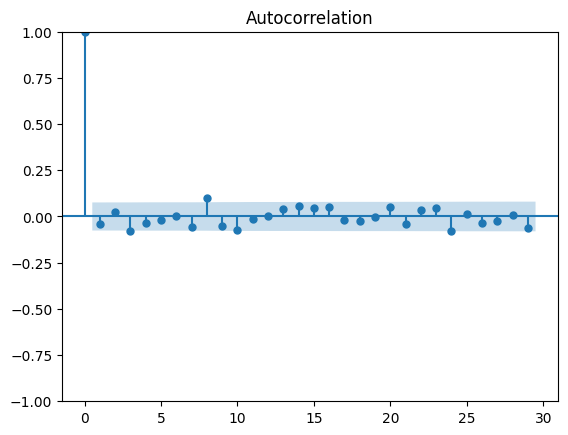

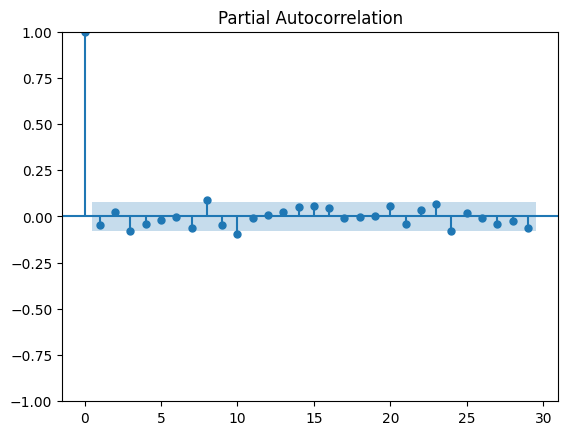

In [59]:
# Check stationarity
sgt.plot_acf(y_train_diff)
sgt.plot_pacf(y_train_diff)

# Grid search ARIMA parameters
best_aic = float("inf")
best_order = None
best_model = None

for p in range(1,12):
    for d in range(0,2):
        for q in range(0,6):
            sm_model = ARIMA(endog=y_train_diff, order=(p,d,q))
            fit = sm_model.fit()
            aic = fit.aic
            if aic < best_aic:
                best_model = fit
                best_order = (p,d,q)
                best_aic = aic

# Refit best model
arima = best_model
arima_name = "ARIMA"+str(best_order)

In [90]:
# Test cointegration
for idx in other_idx:
    print("coint_test("+idx+"):", coint(y0=X_train_diff[target_idx],y1=X_train_diff[idx])[1] < 0.05)

# Fit VAR
sm_model = VAR(X_train_diff)
var = sm_model.fit(maxlags=12, ic='bic')
lag_order = var.k_ar
print("lag_order:", lag_order)
var_name = "VAR("+str(lag_order)+")"

coint_test(Index1): True
coint_test(Index2): True
coint_test(Index3): True
coint_test(Index4): True
coint_test(Index5): True
coint_test(Index6): True
coint_test(Index7): True
lag_order: 1


LinearRegression RMSE: 4.574526538558875
RandomForestRegressor RMSE: 8.658725552592795
AdaBoostRegressor RMSE: 13.145542800161438
ARIMA(9, 0, 4) RMSE: 4.545732457867476
VAR(1) RMSE: 4.513433448565853


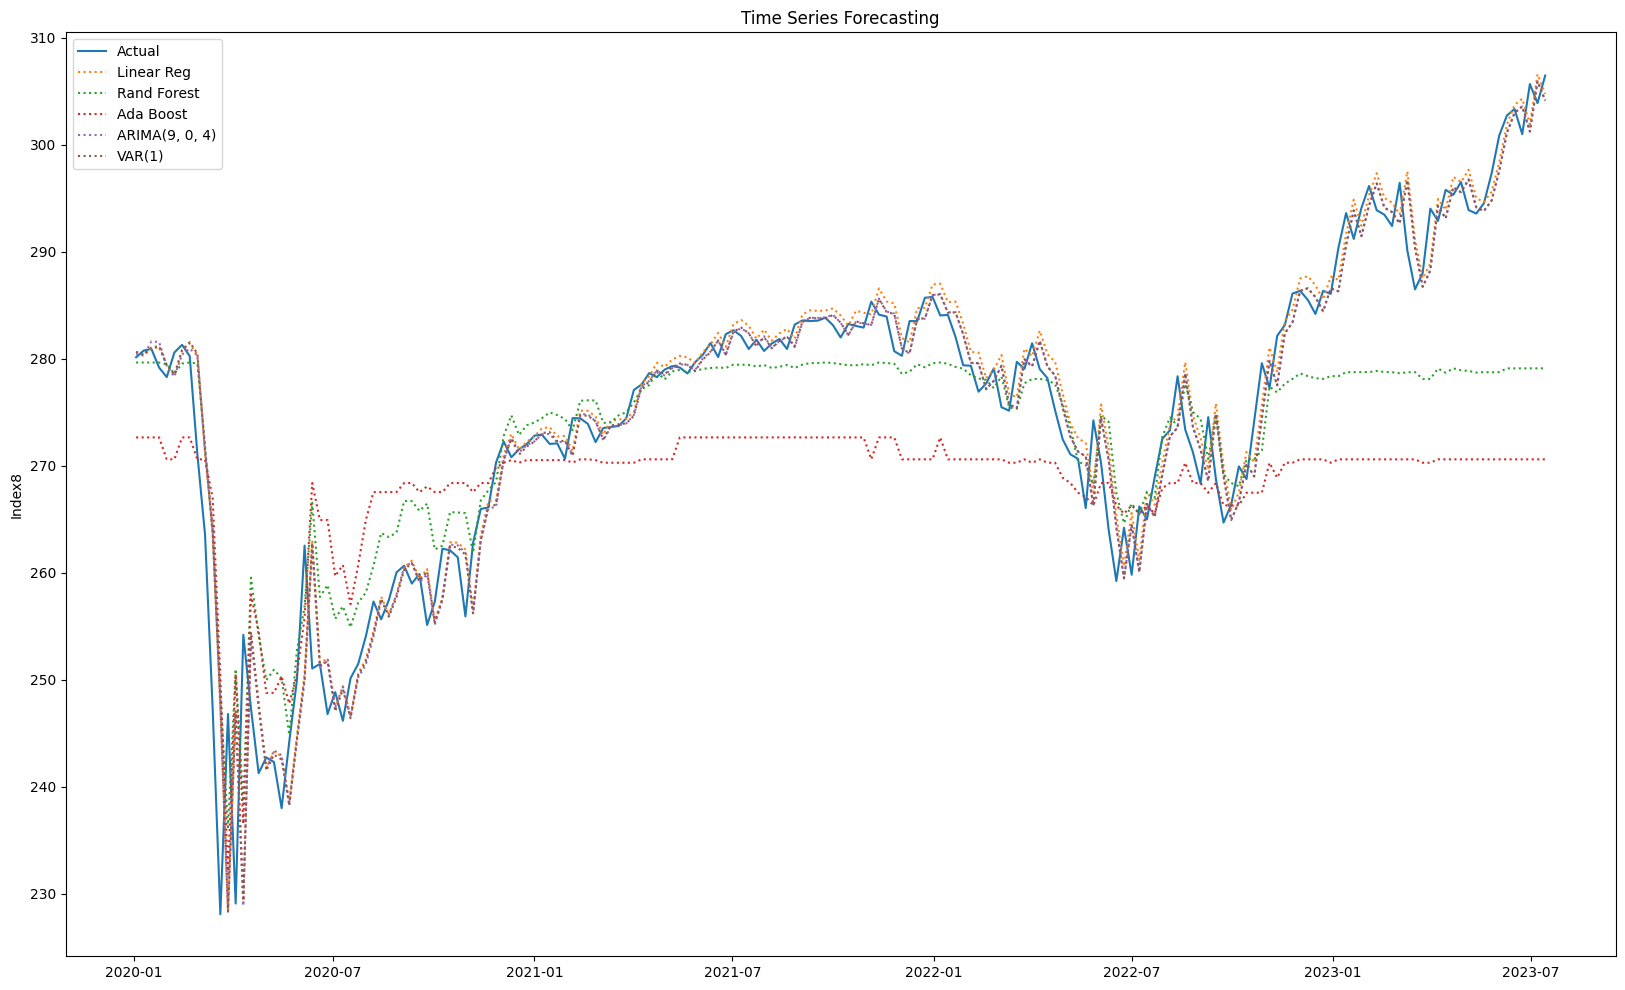

In [91]:
lm_preds = predict(LinearRegression(), X_train, y_train, X_test, y_test)
rf_preds = predict(RandomForestRegressor(), X_train, y_train, X_test, y_test)
ab_preds = predict(AdaBoostRegressor(), X_train, y_train, X_test, y_test)
ar_preds = arima.forecast(steps=len(y_test)) + X_test['Index8'].values
print(arima_name, f'RMSE: {np.sqrt(mean_squared_error(y_test, ar_preds))}')
var_preds = var.forecast(var.endog, steps=len(y_test))[:,-1] + X_test['Index8'].values
print(var_name, f'RMSE: {np.sqrt(mean_squared_error(y_test, var_preds))}')

plt.figure(figsize=(20,12))

# Plot actuals
plt.plot(y_test, label='Actual')

# Plot predictions on same dates
plt.plot(y_test.index, lm_preds, linestyle=':', label='Linear Reg')
plt.plot(y_test.index, rf_preds, linestyle=':', label='Rand Forest')
plt.plot(y_test.index, ab_preds, linestyle=':', label='Ada Boost')
plt.plot(y_test.index, ar_preds, linestyle=':', label=arima_name)
plt.plot(y_test.index, var_preds, linestyle=':', label=var_name)

plt.title('Time Series Forecasting')
plt.ylabel('Index8')
plt.legend()

plt.show()